#CSE/STAT 416 Quiz Section 5

##Bagging, Boosting, Precision and Recall
July 23rd, 2020

Author: Anne Wagner

We have talked a bit about precision and recall, different types of classification error, and when certain types of error might be preferred. To help motivate this with an example, we will consider data on breast cancer scans by the University of Wisconsin.

Data Source: UCI Machine Learning Repository http://archive.ics.uci.edu/ml

In [ ]:
import pandas as pd
import numpy as np
raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
import matplotlib.pyplot as plt

The data we will be looking at consists of different metrics gathered from breast cancer biopsies. Typically our goal in classification to try and accurately classify all classes, but in this particular context it is important to consider the two types of errors.

####Type 1 Error - False Positive
In the context of cancer biopsies, a false positive will likely result in the patient seeking more tests to confirm before starting any treatment. This is not an ideal outcome, but we are more concerned with...

####Type 2 Error - False Negative
A false negative means a patient who does have breast cancer is being told that the test results were benign. This may lead to the patient ignoring the problem until it becomes worse or entirely untreatable. 

While we wish to avoid making either one of these misclassifications, the cost of each of these errors should be considered when choosing a model.

In [ ]:
y=((raw_data[1]=='M')-.5)*2
X=np.vstack((np.log(raw_data[14]),np.log(raw_data[23])))

n=y.shape[0]
inds=np.array(range(n))
np.random.RandomState(416)
np.random.shuffle(inds)

y_train=y[inds[1:(n//2)]]
y_test=y[inds[(n//2):n]]
X_train=X[:,inds[1:(n//2)]]
X_test=X[:,inds[(n//2):n]]

mal=(y==1)
mal_test=(y_test==1)
mal_train=(y_train==1)

In total there are 10 different metrics gathered about the biopsied cells, repeated on 3 perpendicular axes. For the purposes of this exercise, we are going to focus on just two of the variables, chosen to help visualize examples.

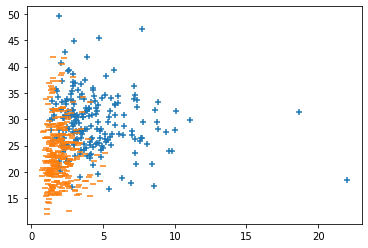

In [ ]:
plt.scatter(np.exp(X[0,][mal]),np.exp(X[1,][mal]),marker='+',cmap="blue")
plt.scatter(np.exp(X[0,][~mal]),np.exp(X[1,][~mal]),marker='_',cmap="red")

Again for the purposes visualization, we are going to convert the data to a log scale. This will have no effect on the classification via decision trees (and related methods). Why is that?

#####Why that is.

Decision trees only branch on a single variable at a time and the logarithm function is one-to-one. A branch at $x<a$ is identical to a branch at $log(x)<log(a)$ 

####The scaled data

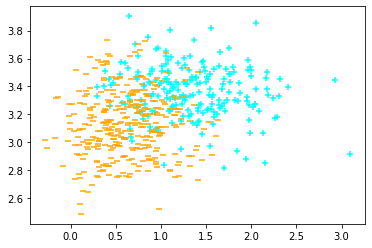

In [ ]:
plt.scatter(X[0,][mal],X[1,][mal],marker='+',c='cyan')
plt.scatter(X[0,][~mal],X[1,][~mal],marker='_',c='orange')

We will use blue (cyan) to denote positive classification, and red (orange) to denote negative classificiation. While there are some regions that are clearly dominated by positive or negative values, there is still considerable overlap for many of the points.

While we seek to minimize classification errors (more so false negatives) we need to consider metrics other than just accuracy, which doesn't account for the type of error, or error count, which doesn't account for the quantity of positive or negative values in the data. To that end we have two metrics to consider.

#Precision and Recall

Precision and recall both relate to the number of true positive observations, but calculate two different rates. 

*Precision* refers to the ability to ensure positives predictions are positive. With an algorithm that is very precise, you can be assured that most positive predictions are actually positive.

$$Precision = \frac{\#\text{True Positives}}{\#\text{True Positives} + \#\text{False Positives}}$$

*Recall* refers to the ability to ensure that cases that are positive are predicted positively. With an algorithm with high recall, you can be assured that you will predict most positive cases correctly.

$$Recall = \frac{\#\text{True Positives}}{\#\text{True Positives} + \#\text{False Negatives}}$$

In the context of this data set, which are we more concerned with, and why? 

Can we create a predictor that scores perfectly on that metric while still being useless?

#####Answer 

We care more about our model having a high recall. That way we can ensure that anyone who does have breast cancer is properly informed. At the same time, we could just classify every case as malignant and achieve a recall of 1, but there is literally no point in taking that test as it offers no value.

#####Example

Let's look at a simple decision tree on this data. We will use a depth of 6.

[['TN' 'FN']
 ['FP' 'TP']]
[[160   7]
 [ 17  99]]


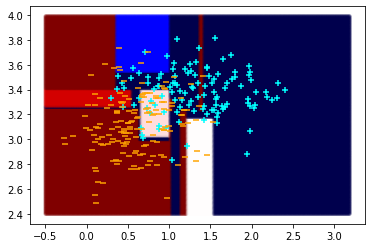

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix as cm
dtm = DecisionTreeClassifier(max_depth=6, random_state=1)
dtm.fit(X_train.T, y_train)
grid=np.meshgrid(np.arange(-.5,3.2,.01),np.arange(2.4,4.0,.01))
grid=np.vstack((grid[0].flatten(),grid[1].flatten()))


print(np.array([['TN','FN'],['FP','TP']]))
print(cm(y_train,dtm.predict(X_train.T)))

out=dtm.predict_proba(grid.T).T[1]
grid_colors=plt.cm.seismic((out-.5)*(-2))
plt.scatter(grid[0,],grid[1,],marker='.',c=grid_colors,alpha=.25)
plt.scatter(X_train[0,][mal_train],X_train[1,][mal_train],marker='+',c='cyan')
plt.scatter(X_train[0,][~mal_train],X_train[1,][~mal_train],marker='_',c="orange")

Take a moment to try and calculate the precision and recall for this training data. Do you see evidence of overfitting in the results? (I certainly do, but the results keep changing from run to run! set.seed has failed me!)

In [ ]:
def print_prec_and_recall(y_true,y_pred):
  cm_out=cm(y_true,y_pred)
  #We can quickly calculate the precision and recall from the confusion matrix
  print(np.array([['TN','FN'],['FP','TP']]))
  print(cm_out)
  print("Precision: ",np.round(cm_out[1,1]/(cm_out[1,1]+cm_out[0,1]),5),"  Recall:", np.round(cm_out[1,1]/(cm_out[1,1]+cm_out[1,0]),5))

In [ ]:
import matplotlib.colors as colors
def error_scatter(X,mal,correct,grid,grid_colors,size=None):
  if size is None:
    plt.scatter(grid[0,],grid[1,],marker='.',c=grid_colors,alpha=.25,cmap=plt.cm.seismic,norm=colors.Normalize(vmin=-1,vmax=1))
    plt.scatter(X[0,][mal & correct],X[1,][mal & correct],marker='+',c='cyan',alpha=.35)
    plt.scatter(X[0,][~mal & correct],X[1,][~mal & correct],marker='_',c="orange",alpha=.35)
    plt.scatter(X[0,][mal & ~correct],X[1,][mal & ~correct],marker='+',c='cyan')
    plt.scatter(X[0,][~mal & ~correct],X[1,][~mal & ~correct],marker='_',c='orange')
  else:
    size=np.sqrt(size)*X.shape[1]*3
    plt.scatter(grid[0,],grid[1,],marker='.',c=grid_colors,alpha=.25,cmap=plt.cm.seismic,norm=colors.Normalize(vmin=-1,vmax=1))
    plt.scatter(X[0,][mal & correct],X[1,][mal & correct],marker='+',c='cyan',alpha=.35,s=size[mal & correct])
    plt.scatter(X[0,][~mal & correct],X[1,][~mal & correct],marker='_',c="orange",alpha=.35,s=size[~mal & correct])
    plt.scatter(X[0,][mal & ~correct],X[1,][mal & ~correct],marker='+',c='cyan',s=size[mal & ~correct])
    plt.scatter(X[0,][~mal & ~correct],X[1,][~mal & ~correct],marker='_',c='orange',s=size[~mal & ~correct])


[['TN' 'FN']
 ['FP' 'TP']]
[[160   7]
 [ 17  99]]
Precision:  0.93396   Recall: 0.85345


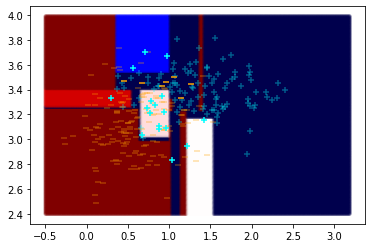

In [ ]:
correct_train=(y_train==dtm.predict(X_train.T))
error_scatter(X_train,mal_train,correct_train,grid,grid_colors)
print_prec_and_recall(y_train,dtm.predict(X_train.T))

[['TN' 'FN']
 ['FP' 'TP']]
[[158  31]
 [ 24  72]]
Precision:  0.69903   Recall: 0.75


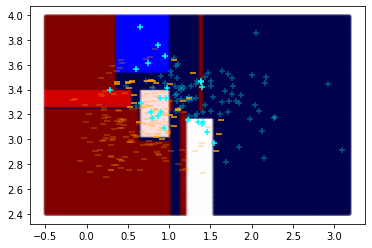

In [ ]:
correct_test=(y_test==dtm.predict(X_test.T))
error_scatter(X_test,mal_test,correct_test,grid,grid_colors)
print_prec_and_recall(y_test,dtm.predict(X_test.T))

We can see here that the precision and recall are around 70% for the unseen data. (Unless it's not, again, I missed some randomization somewhere...) Maintaining this model, is there a way we can improve the recall? If we can, what effect will this have on the precision?

#####Answer

[['TN' 'FN']
 ['FP' 'TP']]
[[100  89]
 [  5  91]]
Precision:  0.50556   Recall: 0.94792


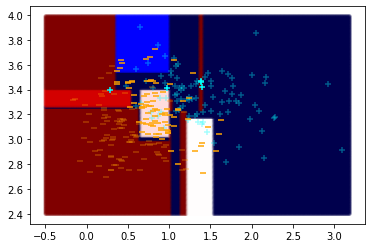

In [ ]:
#We can change the threshold that we classify points
#IE: we will classify as malignant if more than 20% of points on a leaf are malignant
threshold_classification=((dtm.predict_proba(X_test.T)[:,1]>.2)-.5)*2
correct_test=np.array(y_test==threshold_classification)
error_scatter(X_test,mal_test,correct_test,grid,grid_colors)
print_prec_and_recall(y_test,threshold_classification)

#AdaBoost

Adaptive Boosting builds on decision tree classification by taking away most of the tree. AdaBoost instead consists of a large set of decision stumps (a single data split) that are built sequentially to target incorrectly classified data, and weighted according to their accuracy. The algorithm proceeds as follows.

To create a set of $T$ decision stumps to classify $x$, a set of $n$ data points

Initialize:
* Assign each point a *data weight* $\alpha_i=\frac{1}{n}$.

for $t$ in $[1,2,...,T]$:
*   Learn a decision stump $\hat f_t(x)$
* Calculate the $WeightedError$

$$WeightedError = \frac{\sum_{i=1}^n\alpha_i\mathbb{I}_{\hat f_t(x_i)\neq y_i}}{\sum_{i=1}^n\alpha_i}$$

*   Set the *model weight* according to the weighted error
$$\hat{w}_t=\frac{1}{2}ln\left(\frac{1-WeightedError(\hat{f}_t)}{WeightedError(\hat{f}_t)}\right)$$

* Update the *data weights* $\alpha$, shrinking weight on those correctly classified and raising it on the points that are incorrectly classified. (We can get clever with our indicator function, something that will come in handy when coding, note that $2(\mathbb{I}_{\hat f_t(x_i)=y_i}-.5)$ is +1 for incorrectly classified data, and -1 for correctly classified data.)

$$\alpha_i=\alpha_ie^{2(\mathbb{I}_{\hat f_t(x_i)\neq y_i}-.5)\hat{w}_t}$$

To avoid the weights becoming too extreme and causing numerical issues with computation, they can be renormalized each run. 

To make predictions we take 

$$\hat{y}=\hat{F}(x)=sign\left(\sum_{t=1}^T\hat{w}_t\hat{f}_t(x)\right)$$

Because the AdaBoost algorithm doesn't let you see things like *data weights* as the model is fitting, I wrote my own. Let's work through the code together.

<sup><sub>
There may be an error in the code below, in which case you can find the error as an extra exercise. If there isn't an error, then doublechecking it was the exercise. In either case, it was definitely intentional.</sup></sub>

######Hide Large Code Block

In [ ]:
class AdaBoostManual:
  def __init__(self, num_trees, X, y):
    self.stumps=[DecisionTreeClassifier(max_depth=1,random_state=i) for i in range(num_trees)]
    self.data_weights=np.zeros((num_trees,X.shape[1]))
    self.model_weights=np.zeros(num_trees)
    self.X=X
    self.y=y
    self.num_trees=num_trees
    self.stump_predictions=np.zeros((num_trees,X.shape[1]))
    self.predictions=np.zeros((num_trees,X.shape[1]))
    self.psuedoprob=np.zeros((num_trees,X.shape[1]))
    #I just like to save lots of stuff in case I want to use it later.

  def train(self):
    #Initialize for the first tree - data weights are equal.
    self.data_weights[0]=1/self.X.shape[1]
    #The decision stump is fit and a number of variables are saved
    self.stumps[0].fit(self.X.T,self.y)
    self.stump_predictions[0]=self.stumps[0].predict(self.X.T)
    self.predictions[0]=self.stump_predictions[0]
    self.psuedoprob[0]=self.stump_predictions[0]
    #We calculate the errors for this model
    errors=np.array([t for t in self.predictions[0]!=self.y])
    #Which we use to calculate the weighted error (unweighted for the first stump)
    WeightedError=np.sum(errors)/self.X.shape[1];
    #We assign the model weight according to the weighted error
    self.model_weights[0]=0.5*np.log((1-WeightedError)/WeightedError)
    #We use the errors to adjust the weights, the variable
    self.data_weights[0]=self.data_weights[0]*np.exp((errors-.5)*2*self.model_weights[0])
    #Lastly, we normalize
    self.data_weights[0]=self.data_weights[0]/self.data_weights[0].sum()
    for i in range(1,self.num_trees):
      self.stumps[i].fit(self.X.T,self.y,sample_weight=self.data_weights[i-1])
      self.stump_predictions[i]=self.stumps[i].predict(self.X.T)
      #Predictions at each stage are constructed from weighted sums of the previous models
      for j in range(i):
        self.predictions[i]=self.predictions[i]+self.model_weights[j]*self.stump_predictions[j]
      self.psuedoprob[i]=self.predictions[i]/np.max(np.abs(self.predictions[i]))
      #We take the sign of the resulting sum as the predicted value
      self.predictions[i]=np.sign(self.predictions[i])
      errors=np.array([t for t in self.stumps[i].predict(self.X.T)!=self.y])
      WeightedError=np.sum(errors*self.data_weights[i-1])/self.data_weights[i-1].sum();
      #Then we again assign the model weight and update data weights
      self.model_weights[i]=0.5*np.log((1-WeightedError)/WeightedError)
      self.data_weights[i]=self.data_weights[i-1]*np.exp((errors-.5)*2*self.model_weights[i])
      self.data_weights[i]=self.data_weights[i]/self.data_weights[i].sum()

  def predict(self,X_test,early_stop=None):
    preds=np.zeros(X_test.shape[1])
    if early_stop==None:
      for i in range(self.num_trees):
        tmp=self.stumps[i].predict(X_test.T)
        preds=preds+tmp*self.model_weights[i]
    else:
      for i in range(early_stop):
        tmp=self.stumps[i].predict(X_test.T)
        preds=preds+tmp*self.model_weights[i]
    preds=np.sign(preds)
    return(preds)

  #This is not a true probability, but instead returns a value between -1 and 1.
  def psuedoprobpredict(self,X_test,early_stop=None):
    preds=np.zeros(X_test.shape[1])
    if early_stop==None:
      for i in range(self.num_trees):
        tmp=self.stumps[i].predict(X_test.T)
        preds=preds+tmp*self.model_weights[i]
    else:
      for i in range(early_stop):
        tmp=self.stumps[i].predict(X_test.T)
        preds=preds+tmp*self.model_weights[i]
    preds=preds/np.max(np.abs(preds))
    return(preds)

ABE=AdaBoostManual(25, X_train, y_train)
ABE.train()

grid=np.meshgrid(np.arange(-.5,3.2,.01),np.arange(2.4,4.0,.01))
grid=np.vstack((grid[0].flatten(),grid[1].flatten()))

def AdaBoostViewExample(num_trees):
  out=-ABE.psuedoprobpredict(grid,num_trees)

  correct_train=(y_train==ABE.predictions[num_trees-1])
  error_scatter(X_train,mal_train,correct_train,grid,out,size=ABE.data_weights[num_trees-1])
  print_prec_and_recall(y_train,ABE.predictions[num_trees-1])


######Let's look at how weights are changing from run to run

The plots produced by the function $AdaBoostViewExample(k)$ show how the points are being classified after the first $k$ trees. The size of a point is proportional to the weight of the point after the $k$th tree, with the incorrectly classified points emphasized. 

[['TN' 'FN']
 ['FP' 'TP']]
[[151  16]
 [ 25  91]]
Precision:  0.85047   Recall: 0.78448


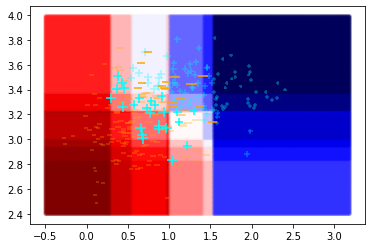

In [ ]:
#Input number between 1 and 24 to see how the classifier is classifying, and weighting points 
AdaBoostViewExample(25) 

[['TN' 'FN']
 ['FP' 'TP']]
[[144  23]
 [ 32  84]]
Precision:  0.78505   Recall: 0.72414


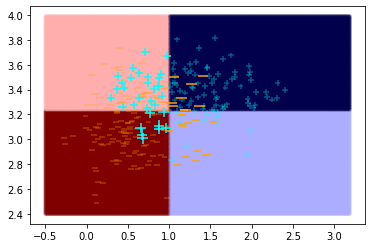

In [ ]:
#Input number between 1 and 24 to see how the classifier is classifying, and weighting points 
AdaBoostViewExample(2) 

The *sklearn* library of course has its own AdaBoost algorithm, capable of either classification or regression. Much easier than writing your own, though it does not give quick and easy access to some of the parameters (such as the model or data weights). 

Question for discussion - how do we do regression in AdaBoost?

[['TN' 'FN']
 ['FP' 'TP']]
[[150  17]
 [ 26  90]]
Precision:  0.84112   Recall: 0.77586


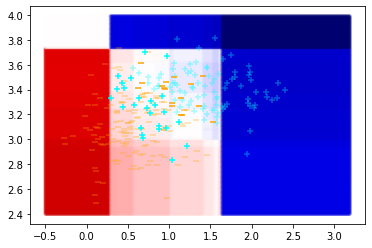

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc=AdaBoostClassifier(n_estimators=25, random_state=1)
abc.fit(X.T, y)

abc_pred=abc.predict_proba(grid.T).T[0]
#training data
correct_train=(y_train==abc.predict(X_train.T))
error_scatter(X_train,mal_train,correct_train,grid,(abc_pred-.5)*2)
print_prec_and_recall(y_train,abc.predict(X_train.T))

[['TN' 'FN']
 ['FP' 'TP']]
[[172  17]
 [ 14  82]]
Precision:  0.82828   Recall: 0.85417


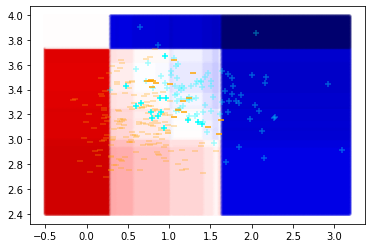

In [ ]:
#testing data
correct_test=(y_test==abc.predict(X_test.T))
error_scatter(X_test,mal_test,correct_test,grid,(abc_pred-.5)*2)
print_prec_and_recall(y_test,abc.predict(X_test.T))

We can even look at the stagewise predictions for only the first $k$ models, but the access is somewhat clunky. Below is the 10th model.

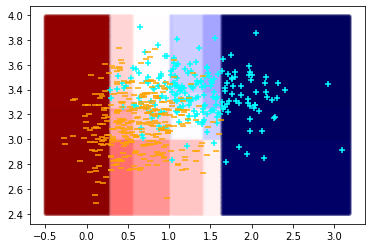

In [ ]:
for i, t in enumerate(abc.staged_predict_proba(grid.T)):
  if(i==10):
    adacolors=plt.cm.seismic(t.T[0])
    plt.scatter(grid[0,],grid[1,],marker='.',c=adacolors,alpha=.25)
    plt.scatter(X[0,][mal],X[1,][mal],marker='+',c='cyan')
    plt.scatter(X[0,][~mal],X[1,][~mal],marker='_',c='orange')

#Random Forests

Random Forests attempt to improve upon decision trees by adding more trees. (Which sounds way better than taking away most of the tree, personally speaking)

To produce a variety of trees from a single data set, we use bootstrap sampling to create a unique size $n$ data set sampled with replacement from the original data. In effect, this weights each point by a multiple of $\frac{1}{n}$, in accordance with the number of times it has been sampled. Similarly, you can randomly select features on which to construct the trees, producing a wider variety of trees that are able to produce a complex decision boundary. 

For a full implementation of random forest, consult the one you already made for homework 4. You all should probably be teaching me this.

#####Random Forrest

<img src="https://occ-0-2794-2219.1.nflxso.net/dnm/api/v6/E8vDc_W8CLv7-yMQu8KMEC7Rrr8/AAAABRH4YM-SODj1fGal_ylc15ebTe90p_j_WPiMUjXpRGFZqMdCtc7zSFJe9C2OliUhCGmyu0APQWKZ3Q6CzAGSA8_D26Sj.jpg" width="400"/>

####Random Forest in *sklearn*:

[['TN' 'FN']
 ['FP' 'TP']]
[[159   8]
 [ 24  92]]
Precision:  0.92   Recall: 0.7931


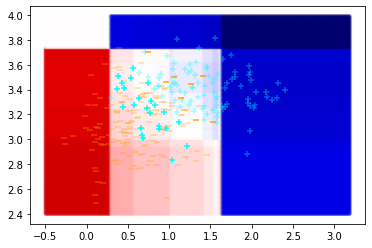

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=25, random_state=1, max_depth=6)
#When I type in rfc google colab autocompletes to RandomForestClassifier
# and I just think that's neat.
rfc.fit(X.T, y)

rfc_pred=abc.predict_proba(grid.T).T[0]
#Train data
correct_train=(y_train==rfc.predict(X_train.T))
error_scatter(X_train,mal_train,correct_train,grid,(rfc_pred-.5)*2)
print_prec_and_recall(y_train,rfc.predict(X_train.T))

[['TN' 'FN']
 ['FP' 'TP']]
[[183   6]
 [ 14  82]]
Precision:  0.93182   Recall: 0.85417


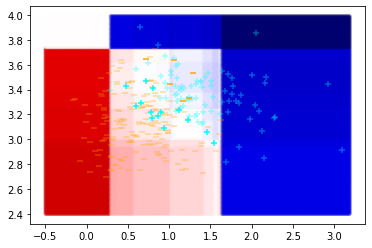

In [ ]:
#Test data
correct_test=(y_test==rfc.predict(X_test.T))
error_scatter(X_test,mal_test,correct_test,grid,(rfc_pred-.5)*2)
print_prec_and_recall(y_test,rfc.predict(X_test.T))

We will leave some time at the end of section for you to meet-and-greet with peers in order to find partners for the next homework. 

Unless I just got to this part and it's the end of section. 

####Confession from Anne

<img src="https://i.imgur.com/X310x55.jpg" width="400"/>